# 9-11. 프로젝트: 네이버 영화 리뷰 감성분석

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

In [2]:
from konlpy.tag import Mecab

def tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []
    
    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence) # 토큰화
        curr_data = [word for word in curr_data if not word in stopwords]
        
        result.append(curr_data)
        
    # result = list(map(' '.join, result))
    return result

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# https://www.ranks.nl/stopwords/korean 
# stopwords_extra = ['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로', '바꾸어서 말하면', '바꾸어서 한다면', '만약', '그렇지않으면', '까악', '툭', '딱', '삐걱거리다', '보드득', '비걱거리다', '꽈당', '응당', '해야한다', '에 가서', '각', '각각', '여러분', '각종', '각자', '제각기', '하도록하다', '와', '과', '그러므로', '그래서', '고로', '한 까닭에', '하기 때문에', '거니와', '이지만', '대하여', '관하여', '관한', '과연', '실로', '아니나다를가', '생각한대로', '진짜로', '한적이있다', '하곤하였다', '하', '하하', '허허', '아하', '거바', '와', '오', '왜', '어째서', '무엇때문에', '어찌', '하겠는가', '무슨', '어디', '어느곳', '더군다나', '하물며', '더욱이는', '어느때', '언제', '야', '이봐', '어이', '여보시오', '흐흐', '흥', '휴', '헉헉', '헐떡헐떡', '영차', '여차', '어기여차', '끙끙', '아야', '앗', '아야', '콸콸', '졸졸', '좍좍', '뚝뚝', '주룩주룩', '솨', '우르르', '그래도', '또', '그리고', '바꾸어말하면', '바꾸어말하자면', '혹은', '혹시', '답다', '및', '그에 따르는', '때가 되어', '즉', '지든지', '설령', '가령', '하더라도', '할지라도', '일지라도', '지든지', '몇', '거의', '하마터면', '인젠', '이젠', '된바에야', '된이상', '만큼 	어찌됏든', '그위에', '게다가', '점에서 보아', '비추어 보아', '고려하면', '하게될것이다', '일것이다', '비교적', '좀', '보다더', '비하면', '시키다', '하게하다', '할만하다', '의해서', '연이서', '이어서', '잇따라', '뒤따라', '뒤이어', '결국', '의지하여', '기대여', '통하여', '자마자', '더욱더', '불구하고', '얼마든지', '마음대로', '주저하지 않고', '곧', '즉시', '바로', '당장', '하자마자', '밖에 안된다', '하면된다', '그래', '그렇지', '요컨대', '다시 말하자면', '바꿔 말하면', '즉', '구체적으로', '말하자면', '시작하여', '시초에', '이상', '허', '헉', '허걱', '바와같이', '해도좋다', '해도된다', '게다가', '더구나', '하물며', '와르르', '팍', '퍽', '펄렁', '동안', '이래', '하고있었다', '이었다', '에서', '로부터', '까지', '예하면', '했어요', '해요', '함께', '같이', '더불어', '마저', '마저도', '양자', '모두', '습니다', '가까스로', '하려고하다', '즈음하여', '다른', '다른 방면으로', '해봐요', '습니까', '했어요', '말할것도 없고', '무릎쓰고', '개의치않고', '하는것만 못하다', '하는것이 낫다', '매', '매번', '들', '모', '어느것', '어느', '로써', '갖고말하자면', '어디', '어느쪽', '어느것', '어느해', '어느 년도', '라 해도', '언젠가', '어떤것', '어느것', '저기', '저쪽', '저것', '그때', '그럼', '그러면', '요만한걸', '그래', '그때', '저것만큼', '그저', '이르기까지', '할 줄 안다', '할 힘이 있다', '너', '너희', '당신', '어찌', '설마', '차라리', '할지언정', '할지라도', '할망정', '할지언정', '구토하다', '게우다', '토하다', '메쓰겁다', '옆사람', '퉤', '쳇', '의거하여', '근거하여', '의해', '따라', '힘입어', '그', '다음', '버금', '두번째로', '기타', '첫번째로', '나머지는', '그중에서', '견지에서', '형식으로 쓰여', '입장에서', '위해서', '단지', '의해되다', '하도록시키다', '뿐만아니라', '반대로', '전후', '전자', '앞의것', '잠시', '잠깐', '하면서', '그렇지만', '다음에', '그러한즉', '그런즉', '남들', '아무거나', '어찌하든지', '같다', '비슷하다', '예컨대', '이럴정도로', '어떻게', '만약', '만일', '위에서 서술한바와같이', '인 듯하다', '하지 않는다면', '만약에', '무엇', '무슨', '어느', '어떤', '아래윗', '조차', '한데', '그럼에도 불구하고', '여전히', '심지어', '까지도', '조차도', '하지 않도록', '않기 위하여', '때', '시각', '무렵', '시간', '동안', '어때', '어떠한', '하여금', '네', '예', '우선', '누구', '누가 알겠는가', '아무도', '줄은모른다', '줄은 몰랏다', '하는 김에', '겸사겸사', '하는바', '그런 까닭에', '한 이유는', '그러니', '그러니까', '때문에', '그', '너희', '그들', '너희들', '타인', '것', '것들', '너', '위하여', '공동으로', '동시에', '하기 위하여', '어찌하여', '무엇때문에', '붕붕', '윙윙', '나', '우리', '엉엉', '휘익', '윙윙', '오호', '아하', '어쨋든', '만 못하다 	하기보다는', '차라리', '하는 편이 낫다', '흐흐', '놀라다', '상대적으로 말하자면', '마치', '아니라면', '쉿', '그렇지 않으면', '그렇지 않다면', '안 그러면', '아니었다면', '하든지', '아니면', '이라면', '좋아', '알았어', '하는것도', '그만이다', '어쩔수 없다', '하나', '일', '일반적으로', '일단', '한켠으로는', '오자마자', '이렇게되면', '이와같다면', '전부', '한마디', '한항목', '근거로', '하기에', '아울러', '하지 않도록', '않기 위해서', '이르기까지', '이 되다', '로 인하여', '까닭으로', '이유만으로', '이로 인하여', '그래서', '이 때문에', '그러므로', '그런 까닭에', '알 수 있다', '결론을 낼 수 있다', '으로 인하여', '있다', '어떤것', '관계가 있다', '관련이 있다', '연관되다', '어떤것들', '에 대해', '이리하여', '그리하여', '여부', '하기보다는', '하느니', '하면 할수록', '운운', '이러이러하다', '하구나', '하도다', '다시말하면', '다음으로', '에 있다', '에 달려 있다', '우리', '우리들', '오히려', '하기는한데', '어떻게', '어떻해', '어찌됏어', '어때', '어째서', '본대로', '자', '이', '이쪽', '여기', '이것', '이번', '이렇게말하자면', '이런', '이러한', '이와 같은', '요만큼', '요만한 것', '얼마 안 되는 것', '이만큼', '이 정도의', '이렇게 많은 것', '이와 같다', '이때', '이렇구나', '것과 같이', '끼익', '삐걱', '따위', '와 같은 사람들', '부류의 사람들', '왜냐하면', '중의하나', '오직', '오로지', '에 한하다', '하기만 하면', '도착하다', '까지 미치다', '도달하다', '정도에 이르다', '할 지경이다', '결과에 이르다', '관해서는', '여러분', '하고 있다', '한 후', '혼자', '자기', '자기집', '자신', '우에 종합한것과같이', '총적으로 보면', '총적으로 말하면', '총적으로', '대로 하다', '으로서', '참', '그만이다', '할 따름이다', '쿵', '탕탕', '쾅쾅', '둥둥', '봐', '봐라', '아이야', '아니', '와아', '응', '아이', '참나', '년', '월', '일', '령', '영', '일', '이', '삼', '사', '오', '육', '륙', '칠', '팔', '구', '이천육', '이천칠', '이천팔', '이천구', '하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '령', '영']

# stopwords = stopwords + stopwords_extra

def load_data(train_data, test_data, num_words=10000):
    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # NaN 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')
    
    # 토큰화 및 불용어 제거
    X_train = tokenize_and_remove_stopwords(train_data['document'], stopwords, tokenizer)
    X_test = tokenize_and_remove_stopwords(test_data['document'], stopwords, tokenizer)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

print(X_train[10]) # 확인

[2, 4, 39, 229, 6, 535]


In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

get_decoded_sentence(X_train[10], index_to_word) # 확인

'. 진짜 짱 다 ♥'

## 3) 모델 구성을 위한 데이터 분석 및 가공

In [4]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen: ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# 적절한 최대 문장 길이 (pad_sequences_maxlen): 41

문장길이 평균:  15.969376315021577
문장길이 최대:  116
문장길이 표준편차:  12.843535456326455
pad_sequences maxlen:  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [5]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## 4) 모델 구성 및 validation set 구성

In [6]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 모델 1: RNN
'''
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
'''

# 모델 2: 1-D CNN (1)
'''
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
'''

# 모델 3: 1-D CNN (2)
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 1608      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련

In [7]:
# validation set 분리 (임의로 50000건 설정)
X_val = X_train[:50000]
y_val = y_train[:50000]

partial_X_train = X_train[50000:]
partial_y_train = y_train[50000:]

# print(partial_X_train.shape)
# print(partial_y_train.shape)

# 학습 시작
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# epochs = 20
epochs = 15

history = model.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/15
188/188 [==============================] - 4s 21ms/step - loss: 0.4976 - accuracy: 0.7940 - val_loss: 0.3588 - val_accuracy: 0.8429
Epoch 2/15
188/188 [==============================] - 4s 20ms/step - loss: 0.3223 - accuracy: 0.8633 - val_loss: 0.3386 - val_accuracy: 0.8522
Epoch 3/15
188/188 [==============================] - 4s 20ms/step - loss: 0.2700 - accuracy: 0.8897 - val_loss: 0.3418 - val_accuracy: 0.8532
Epoch 4/15
188/188 [==============================] - 4s 20ms/step - loss: 0.2285 - accuracy: 0.9103 - val_loss: 0.3555 - val_accuracy: 0.8525
Epoch 5/15
188/188 [==============================] - 4s 20ms/step - loss: 0.1878 - accuracy: 0.9311 - val_loss: 0.3753 - val_accuracy: 0.8519
Epoch 6/15
188/188 [==============================] - 4s 20ms/step - loss: 0.1485 - accuracy: 0.9493 - val_loss: 0.4054 - val_accuracy: 0.8483
Epoch 7/15
188/188 [==============================] - 4s 20ms/step - loss: 0.1113 - accuracy: 0.9656 - val_loss: 0.4368 - val_accuracy: 0.8446

In [8]:
# 테스트 셋으로 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.7119 - accuracy: 0.8315
[0.7119163274765015, 0.8315397500991821]


## 6) loss, accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


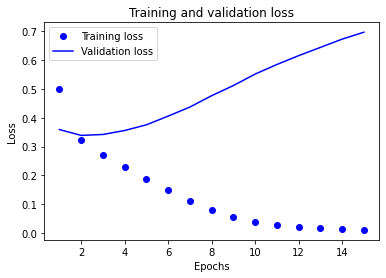

In [9]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# training and validation loss

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

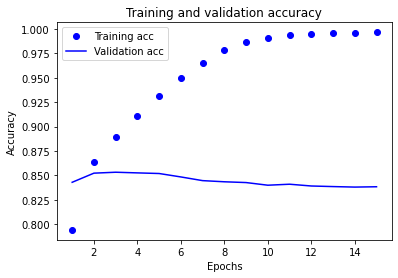

In [10]:
plt.clf() # 그림을 초기화합니다

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 embedding 레이어 분석

In [11]:
# gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = 'word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [12]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['짜증']
vector

array([-0.03251353, -0.06839322, -0.1138526 ,  0.16364762, -0.03628816,
       -0.09643628, -0.07076682, -0.02264139,  0.02602107, -0.09654023,
       -0.08085547, -0.04342678, -0.08712085,  0.0793348 , -0.08976958,
       -0.06020071, -0.08390563, -0.11545346, -0.01924392, -0.08215418,
        0.09143356, -0.10518647,  0.05347978, -0.00900192, -0.06414169,
       -0.10518866, -0.03868299, -0.10546599, -0.05536991, -0.02806398,
        0.12632693,  0.020235  , -0.04583343, -0.07198749,  0.0624716 ,
       -0.03850498, -0.01944011,  0.00525736, -0.06203613, -0.10280845,
       -0.06672879, -0.11551769, -0.04043263, -0.05127222, -0.0919462 ,
        0.11128458, -0.0129028 , -0.02589302,  0.16054915, -0.00637201,
       -0.09207883, -0.07779438, -0.10118309, -0.00761801, -0.10751953,
       -0.08793128,  0.05143717, -0.10981461,  0.08854376, -0.03801231,
       -0.05985857, -0.05480541, -0.08275139, -0.13054222,  0.04893341,
        0.12453657, -0.04815783,  0.15660359,  0.05786481, -0.10

In [13]:
word_vectors.similar_by_word("재미")

[('하', 0.4809167981147766),
 ('신경', 0.47514617443084717),
 ('진짜', 0.4645177721977234),
 ('했', 0.45241010189056396),
 ('영화', 0.45089179277420044),
 ('고', 0.44470852613449097),
 ('다', 0.43090760707855225),
 ('.', 0.4217946231365204),
 ('까지', 0.4203965663909912),
 ('시리즈', 0.4203202426433563)]

## 8) 한국어 word2vec 임베딩 활용해 성능 개선

In [14]:
# from gensim.models import KeyedVectors
import gensim

word2vec_path = 'ko.bin'
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=False)
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['감동']
vector

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


array([-1.4411083 , -0.78142536,  2.453768  , -0.86445606,  0.24195324,
        0.36006922, -1.0639709 ,  0.85037315, -1.0184479 ,  0.21196692,
       -0.6679936 ,  0.6389819 , -0.26964295,  0.66028535,  0.39613017,
        0.6428288 ,  0.6648245 ,  0.08363932, -0.2540794 ,  0.55310047,
        0.63392764,  0.19311981, -0.4648248 ,  0.1490374 ,  2.0762694 ,
        0.7872764 , -0.21711552, -0.59049505, -1.3264338 , -0.06233318,
        1.2550159 , -0.05334642, -0.5453753 , -0.8736315 ,  0.5253877 ,
        0.03122815,  0.8280226 ,  0.23597455,  0.06136359,  1.5114233 ,
       -0.340495  ,  0.912277  ,  0.5899006 , -1.3025732 , -0.87596595,
        0.21738248,  1.0366931 , -0.55709684, -0.9039502 ,  0.28133616,
       -1.7572548 , -0.29769212, -0.14536098,  0.5850025 , -0.6111547 ,
       -0.29829553,  1.4106004 , -0.38685524,  0.4801454 ,  0.40166005,
        0.28174093,  1.6133646 , -0.8590998 ,  0.49886975,  0.38605362,
       -0.1607663 , -0.87983316,  0.21996935,  0.68561727, -0.84

In [15]:
word2vec.similar_by_word("로맨틱")

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('코미디', 0.7576364874839783),
 ('로맨스', 0.7021660804748535),
 ('스릴러', 0.6693053841590881),
 ('개그', 0.6552960872650146),
 ('주제곡', 0.6495761871337891),
 ('뮤지컬', 0.6382304430007935),
 ('시트콤', 0.6167846322059631),
 ('서부극', 0.6151247620582581),
 ('연극과', 0.6083630323410034),
 ('서정적', 0.5965933799743652)]

In [16]:
from tensorflow import keras

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터) 
# could not broadcast input array from shape (200) into shape (300)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [17]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성

# 모델 1: RNN
'''
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
'''

# 모델 2: 1-D CNN (1)
'''
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
'''

# 모델 3: 1-D CNN (2)
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
# epochs = 20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
epochs = 15

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
188/188 [==============================] - 4s 20ms/step - loss: 0.5119 - accuracy: 0.7651 - val_loss: 0.3643 - val_accuracy: 0.8424
Epoch 2/15
188/188 [==============================] - 4s 20ms/step - loss: 0.3251 - accuracy: 0.8632 - val_loss: 0.3404 - val_accuracy: 0.8526
Epoch 3/15
188/188 [==============================] - 4s 20ms/step - loss: 0.2722 - accuracy: 0.8904 - val_loss: 0.3430 - val_accuracy: 0.8533
Epoch 4/15
188/188 [==============================] - 4s 21ms/step - loss: 0.2297 - accuracy: 0.9112 - val_loss: 0.3555 - val_accuracy: 0.8531
Epoch 5/15
188/188 [==============================] - 4s 20ms/step - loss: 0.1890 - accuracy: 0.9308 - val_loss: 0.3768 - val_accuracy: 0.8505
Epoch 6/15
188/188 [==============================] - 4s 20ms/step - loss: 0.1494 - accuracy: 0.9491 - val_loss: 0.4020 - val_accuracy: 0.8491
Epoch 7/15
188/188 [==============================] - 4s 20ms/step - loss: 0.1131 - accuracy: 0.9657 - val_loss: 0.4379 - val_accuracy: 0.8445

In [19]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.7090 - accuracy: 0.8315
[0.7090493440628052, 0.8315397500991821]
